In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
plt.style.use('seaborn-v0_8')


Definimos as bibliotecas que iremos utilizar, vamos gerar nosso dataframe:

In [85]:
np.random.seed(42)
cepas = ['WT', 'C1', 'C2', 'C3', 'C4', 'C5']
tempos = np.arange(2, 72, 2)  # de 0h até 72h, de 2 em 2h

# Condições de fermentação
ph_values = [6.5, 7.0, 7.5]
temp_values = [30, 35, 40]  # em °C
oxigenacao = [20, 40, 60]   # %

# Gerar as linhas
linhas = []
for cepa in cepas:
    for ph in ph_values:
        for temp in temp_values:
            for o2 in oxigenacao:
                glicose = 50
                phb = 0
                od = 0.05
                for t in tempos:
                    # Simulação com influência de pH, temp e oxigenação
                    consumo = np.random.uniform(0.2, 0.5) * (1 + (temp-35)/100) * (1 + (ph-7)/10)
                    glicose = max(0, glicose - consumo)
                    producao = np.random.uniform(0.05, 0.25) * (1 + (o2-40)/100)
                    phb += producao
                    od += np.random.uniform(0.02, 0.05)

                    linhas.append([cepa, t, ph, temp, o2, glicose, phb, od])

df = pd.DataFrame(linhas, columns=['Cepa', 'Tempo_h', 'pH', 'Temperatura_C', 'Oxigenacao_%', 'Glicose_gL', 'PHB_gL', 'OD600'])

display(df.head(100))


,Cepa,Tempo_h,pH,Temperatura_C,Oxigenacao_%,Glicose_gL,PHB_gL,OD600
0,WT,2,6.5,30,20,49.718093,0.192114,0.091960
1,WT,4,6.5,30,20,49.375506,0.257077,0.116640
2,WT,6,6.5,30,20,49.179280,0.435665,0.154673
3,WT,8,6.5,30,20,48.807070,0.478959,0.203770
4,WT,10,6.5,30,20,48.401186,0.552933,0.229225
...,...,...,...,...,...,...,...,...
95,WT,52,6.5,30,60,41.308708,5.152071,0.996645
96,WT,54,6.5,30,60,41.050627,5.353871,1.017560
97,WT,56,6.5,30,60,40.860015,5.611295,1.048366
98,WT,58,6.5,30,60,40.645113,5.796634,1.091466


Geramos o dataframe com valores que a literatura cientifica da área normalmente trabalha nos experimentos. Simulando a medição de 6 cepas, em diferentes temperaturas, Phs e oxigenação.

In [86]:
print("\nInformações gerais:")
print(df.info())


Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5670 entries, 0 to 5669
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Cepa           5670 non-null   object 
 1   Tempo_h        5670 non-null   int32  
 2   pH             5670 non-null   float64
 3   Temperatura_C  5670 non-null   int64  
 4   Oxigenacao_%   5670 non-null   int64  
 5   Glicose_gL     5670 non-null   float64
 6   PHB_gL         5670 non-null   float64
 7   OD600          5670 non-null   float64
dtypes: float64(4), int32(1), int64(2), object(1)
memory usage: 310.1+ KB
None


In [56]:
df.isnull().sum()

Cepa             0
Tempo_h          0
pH               0
Temperatura_C    0
Oxigenacao_%     0
Glicose_gL       0
PHB_gL           0
OD600            0
dtype: int64

In [87]:
print("\nEstatísticas descritivas:")
display(df.describe())


Estatísticas descritivas:


,Tempo_h,pH,Temperatura_C,Oxigenacao_%,Glicose_gL,PHB_gL,OD600
count,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000,5670.000000
mean,36.000000,7.000000,35.000000,40.000000,43.677480,2.677903,0.675546
std,20.200791,0.408284,4.082843,16.331372,3.588599,1.609415,0.351765
min,2.000000,6.500000,30.000000,20.000000,35.211302,0.040066,0.070043
25%,18.000000,6.500000,30.000000,20.000000,40.646910,1.324042,0.372428
50%,36.000000,7.000000,35.000000,40.000000,43.689083,2.594889,0.675726
75%,54.000000,7.500000,40.000000,60.000000,46.783413,3.864091,0.978319
max,70.000000,7.500000,40.000000,60.000000,49.806866,7.175449,1.401786


Acima fiz uma análise básica dos dados para verificar se o dataset foi gerado da forma que precisamos. 

In [88]:
def tempo_90(grupo: pd.DataFrame) -> float:
    grupo = grupo.sort_values('Tempo_h')
    phb_final = grupo.loc[grupo['Tempo_h'].idxmax(), 'PHB_gL']
    alvo = 0.9 * phb_final
    atingiu = grupo[grupo['PHB_gL'] >= alvo]
    if len(atingiu) == 0:
        return np.nan
    return float(atingiu['Tempo_h'].iloc[0])

Na função acima calculamos o tempo mínimo em que a produção de PHB atingiu 90% do valor final registrado para a cepa. Essa função irá nos ajudar a medir a rapidez de produção. Quando chamada, ela irá ordenar os horários recebidos por ordem crescente e retornar o menor tempo em que a produção atingiu esse limite. 

In [89]:
def calcular_metricas(df: pd.DataFrame) -> pd.DataFrame:
    # Ordena por tempo
    df_sorted = df.sort_values('Tempo_h')

    # Agrupa por Cepa + Condições
    resumo = (
        df_sorted.groupby(['Cepa', 'pH', 'Temperatura_C', 'Oxigenacao_%'], group_keys=False)
        .apply(lambda x: pd.Series({
            'PHB_final_gL': x.loc[x['Tempo_h'].idxmax(), 'PHB_gL'],
            'Glicose_inicial_gL': x.loc[x['Tempo_h'].idxmin(), 'Glicose_gL'],
            'Glicose_final_gL': x.loc[x['Tempo_h'].idxmax(), 'Glicose_gL'],
            'OD_final': x.loc[x['Tempo_h'].idxmax(), 'OD600']
        }))
    )

    # Glicose consumida e rendimento
    resumo['Glicose_consumida_gL'] = resumo['Glicose_inicial_gL'] - resumo['Glicose_final_gL']
    resumo['Rendimento_PHB_por_gGlicose'] = resumo['PHB_final_gL'] / resumo['Glicose_consumida_gL']

    # T90 (tempo para atingir 90% do PHB final) por grupo
    t90 = df.groupby(['Cepa', 'pH', 'Temperatura_C', 'Oxigenacao_%'], group_keys=False).apply(tempo_90).rename('T90_h')
    resumo = resumo.join(t90)

    # Produtividade média
    tempo_total = df['Tempo_h'].max() - df['Tempo_h'].min()
    resumo['Produtividade_media_gL_h'] = resumo['PHB_final_gL'] / tempo_total

    # Ordena por produção final
    resumo = resumo.sort_values('PHB_final_gL', ascending=False)
    return resumo


resumo = calcular_metricas(df)
display(resumo.head(10))


<ipython-input-86-41623eea970c>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({
<ipython-input-86-41623eea970c>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  t90 = df.groupby(['Cepa', 'pH', 'Temperatura_C', 'Oxigenacao_%'], group_keys=False).apply(tempo_90).rename('T90_h')


PHB_final_gL  Glicose_inicial_gL  \
Cepa pH  Temperatura_C Oxigenacao_%                                     
WT   7.5 35            60                7.175449           49.486335   
C3   6.5 40            60                7.147908           49.501722   
     7.0 40            60                7.130488           49.625452   
C1   7.0 40            60                7.125060           49.519972   
C5   6.5 30            60                7.091370           49.593012   
         35            60                7.084892           49.526566   
WT   7.5 30            60                7.045791           49.526659   
     6.5 30            60                7.021813           49.670930   
C2   7.0 35            60                6.874982           49.516267   
C3   7.5 35            60                6.782177           49.564209   

                                     Glicose_final_gL  OD_final  \
Cepa pH  Temperatura_C Oxigenacao_%                               
WT   7.5 35            60                   36.736728  1.231270   
C3   6.5 40            60                   38.423560  1.182075   
     7.0 40            60                   35.757675  1.177321   
C1   7.0 40            60                   36.558376  1.215655   
C5   6.5 30            60                   39.463064  1.246512   
         35            60                   38.376111  1.259656   
WT   7.5 30            60                   37.727890  1.265214   
     6.5 30            60                   39.097123  1.310809   
C2   7.0 35            60                   37.128069  1.236669   
C3   7.5 35            60                   37.092463  1.322815   

                                     Glicose_consumida_gL  \
Cepa pH  Temperatura_C Oxigenacao_%                         
WT   7.5 35            60                       12.749607   
C3   6.5 40            60                       11.078163   
     7.0 40            60                       13.867778   
C1   7.0 40            60                       12.961597   
C5   6.5 30            60                       10.129948   
         35            60                       11.150455   
WT   7.5 30            60                       11.798770   
     6.5 30            60                       10.573808   
C2   7.0 35            60                       12.388198   
C3   7.5 35            60                       12.471745   

                                     Rendimento_PHB_por_gGlicose  T90_h  \
Cepa pH  Temperatura_C Oxigenacao_%                                       
WT   7.5 35            60                               0.562798   64.0   
C3   6.5 40            60                               0.645225   62.0   
     7.0 40            60                               0.514177   66.0   
C1   7.0 40            60                               0.549705   64.0   
C5   6.5 30            60                               0.700040   62.0   
         35            60                               0.635390   62.0   
WT   7.5 30            60                               0.597163   64.0   
     6.5 30            60                               0.664076   64.0   
C2   7.0 35            60                               0.554962   66.0   
C3   7.5 35            60                               0.543803   66.0   

                                     Produtividade_media_gL_h  
Cepa pH  Temperatura_C Oxigenacao_%                            
WT   7.5 35            60                            0.105521  
C3   6.5 40            60                            0.105116  
     7.0 40            60                            0.104860  
C1   7.0 40            60                            0.104780  
C5   6.5 30            60                            0.104285  
         35            60                            0.104190  
WT   7.5 30            60                            0.103615  
     6.5 30            60                            0.103262  
C2   7.0 35            60                            0.101103  
C3   7.5 35      

A função organiza e resume os dados do experimento, agrupando-os por cepa para facilitar a interpretação das métricas de desempenho. Para cada cepa, ela calcula o PHB final (PHB_final_gL), que representa a concentração de PHB ao término da fermentação, bem como os valores de glicose inicial (Glicose_inicial_gL) e final (Glicose_final_gL). Além disso, determina o OD600 final (OD_final), que indica a quantidade de biomassa celular acumulada.

A função também calcula a glicose consumida (Glicose_consumida_gL), obtida pela diferença entre a glicose inicial e final, e o rendimento da conversão de glicose em PHB (Rendimento_PHB_por_gGlicose). Outro indicador importante é o T90_h, que mostra o tempo necessário para a cepa atingir 90% da produção máxima de PHB. Por fim, é calculada a produtividade média (Produtividade_media_gL_h), que relaciona a produção final de PHB com o tempo total do processo de fermentação.

Os resultados são apresentados em uma tabela organizada em ordem decrescente de PHB final, destacando as cepas mais produtivas.

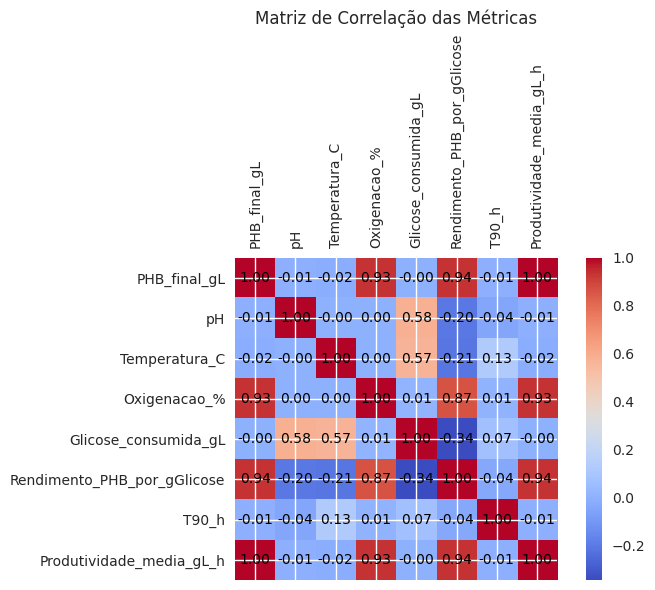

Coeficientes da regressão múltipla:
  pH: -0.0126
  Temperatura_C: -0.0040
  Oxigenacao_%: 0.0544
Intercepto: 3.2766


In [90]:
# Reset índice para ter as colunas acessíveis
resumo_reset = resumo.reset_index()

# Calcular matriz de correlação
corr_vars = ['PHB_final_gL', 'pH', 'Temperatura_C', 'Oxigenacao_%', 'Glicose_consumida_gL', 'Rendimento_PHB_por_gGlicose', 'T90_h', 'Produtividade_media_gL_h']
corr_matrix = resumo_reset[corr_vars].corr()

# Plotar matriz de correlação com matplotlib
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.matshow(corr_matrix, cmap='coolwarm')
plt.colorbar(cax)

# Ajustar ticks com nomes das colunas
ax.set_xticks(range(len(corr_vars)))
ax.set_yticks(range(len(corr_vars)))
ax.set_xticklabels(corr_vars, rotation=90)
ax.set_yticklabels(corr_vars)

# Mostrar os valores das correlações
for (i, j), val in np.ndenumerate(corr_matrix.values):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

plt.title('Matriz de Correlação das Métricas')
plt.tight_layout()
plt.show()

# Regressão múltipla
X = resumo_reset[['pH', 'Temperatura_C', 'Oxigenacao_%']]
y = resumo_reset['PHB_final_gL']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

print("Coeficientes da regressão múltipla:")
for var, coef in zip(X.columns, model.coef_):
    print(f"  {var}: {coef:.4f}")
print(f"Intercepto: {model.intercept_:.4f}")

O heatmap de correlação revela que poucas variáveis apresentam relações fortes com a produção final de PHB, indicando a complexidade do processo. A produtividade média e o PHB final estão quase equivalentes, sugerindo multicolinearidade, enquanto a oxigenação e o rendimento da glicose têm impactos moderados na produção. O pH e a temperatura mostram pouca correlação, o que sugere que efeitos não lineares ou interações podem estar em jogo. Os coeficientes da regressão linear confirmam que a oxigenação tem o maior impacto positivo, seguida pelo pH, enquanto a temperatura exerce um efeito negativo leve. Dada essa complexidade e os resultados, é recomendável explorar modelos de regressão mais avançados que capturem relações não lineares e possíveis interações entre variáveis para otimizar melhor a produção no experimento.


R² do modelo: 0.869


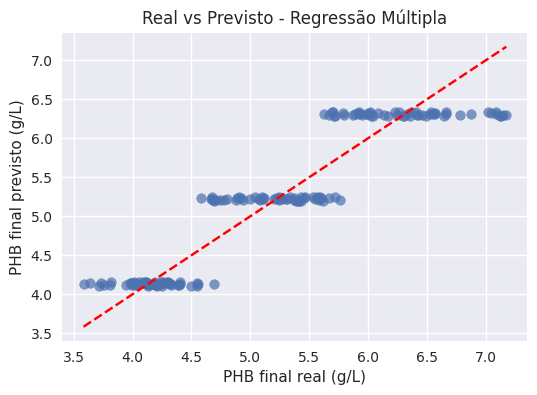

In [91]:
r2 = r2_score(y, y_pred)
print(f"\nR² do modelo: {r2:.3f}")

# Gráfico real vs previsto
plt.figure(figsize=(6,4))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('PHB final real (g/L)')
plt.ylabel('PHB final previsto (g/L)')
plt.title('Real vs Previsto - Regressão Múltipla')
plt.grid(True)
plt.show()


Este gráfico de dispersão compara os valores reais de PHB final com os valores previstos pelo modelo de regressão múltipla, representados no eixo X e Y, respectivamente. A linha vermelha tracejada indica a linha ideal onde os valores previstos seriam exatamente iguais aos reais. Quanto mais próximos os pontos azuis estiverem dessa linha, melhor é a precisão do modelo. Observa-se que o modelo prevê bem os valores mais baixos de PHB, mas tende a subestimar os valores mais altos, indicando uma limitação na capacidade de prever as maiores produções. Em resumo, o modelo apresenta desempenho razoável, porém perde precisão para os casos de maior PHB, possivelmente devido ao vies de nossos dados terem sido gerados automaticamente. Como previsto e comum em problemas de bioprocessos, precisamos de uma otimização de multiplos objetivos. 

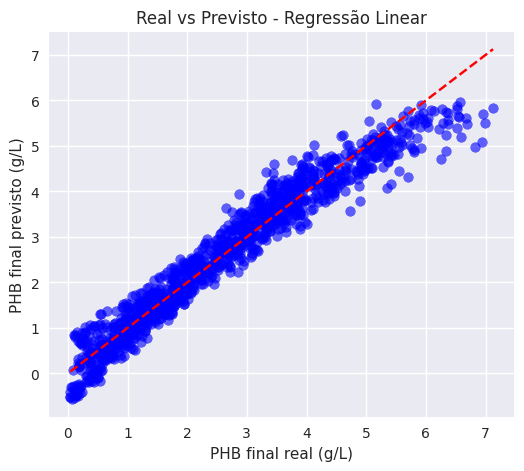

In [92]:
# Selecionar as variáveis preditoras
X = df[["pH", "Temperatura_C", "Oxigenacao_%", "Glicose_gL", "OD600"]].values

# Variável alvo
y = df["PHB_gL"].values

# Embaralhar os índices
np.random.seed(42)
indices = np.random.permutation(len(X))

# Definir tamanho do conjunto de teste
test_size = int(len(X) * 0.2)

# Separar os conjuntos
X_train = X[indices[:-test_size]]
X_test = X[indices[-test_size:]]
y_train = y[indices[:-test_size]]
y_test = y[indices[-test_size:]]


# Resolver por equação normal: beta = (XᵀX)^(-1)Xᵀy
X_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]  # Adiciona bias (coluna de 1s)
theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_train)

X_test_b = np.c_[np.ones((X_test.shape[0], 1)), X_test]
y_pred = X_test_b.dot(theta)


plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("PHB final real (g/L)")
plt.ylabel("PHB final previsto (g/L)")
plt.title("Real vs Previsto - Regressão Linear")
plt.grid(True)
plt.show()


O gráfico compara os valores reais de PHB final (eixo X) com os valores previstos pelo modelo (eixo Y), onde a linha vermelha representa a previsão perfeita. Os pontos estão alinhados próximo a essa linha, mostrando que o modelo prevê bem a produção de PHB. Há pouca dispersão e viés, indicando bom aprendizado das variáveis. Contudo, há uma leve tendência de subestimar os valores mais altos (acima de 6 g/L), sugerindo que modelos que capturem não linearidades ou ajustes podem ser úteis para melhorar essas previsões.

In [93]:
# Calcular a produtividade
df["Produtividade"] = df["PHB_gL"] / df["Tempo_h"]

# Ordenar do mais produtivo para o menos
melhores_condicoes = df.sort_values(by="Produtividade", ascending=False)

# Mostrar as top 10 condições com alta produtividade
melhores_condicoes_top10 = melhores_condicoes[["Cepa", "PHB_gL", "Tempo_h", "Produtividade", "pH", "Temperatura_C", "Oxigenacao_%", "Glicose_gL", "OD600"]].head(10)
display(melhores_condicoes_top10)


,Cepa,PHB_gL,Tempo_h,Produtividade,pH,Temperatura_C,Oxigenacao_%,Glicose_gL,OD600
1750,C1,0.292009,2,0.146005,7.5,35,60,49.668394,0.090915
2695,C2,0.288146,2,0.144073,7.5,35,60,49.581871,0.091890
5110,C5,0.284943,2,0.142471,7.0,30,60,49.793572,0.087588
2800,C2,0.283568,2,0.141784,7.5,40,60,49.614444,0.087500
2696,C2,0.560364,4,0.140091,7.5,35,60,49.355476,0.137771
1751,C1,0.559120,4,0.139780,7.5,35,60,49.432179,0.125332
1645,C1,0.278292,2,0.139146,7.5,30,60,49.695269,0.087069
4060,C4,0.273675,2,0.136838,6.5,40,60,49.717332,0.086500
1648,C1,1.082597,8,0.135325,7.5,30,60,48.501320,0.186918
1649,C1,1.335820,10,0.133582,7.5,30,60,48.079888,0.232269


In [94]:
theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_train)
# Variáveis usadas no modelo
variaveis = ["Intercepto", "pH", "Temperatura_C", "Oxigenacao_%", "Glicose_gL", "OD600"]

# Exibir os coeficientes
for nome, valor in zip(variaveis, theta):
    print(f"{nome}: {valor:.4f}")

Intercepto: 12.6166
pH: -0.1739
Temperatura_C: -0.0197
Oxigenacao_%: 0.0279
Glicose_gL: -0.2380
OD600: 1.8419


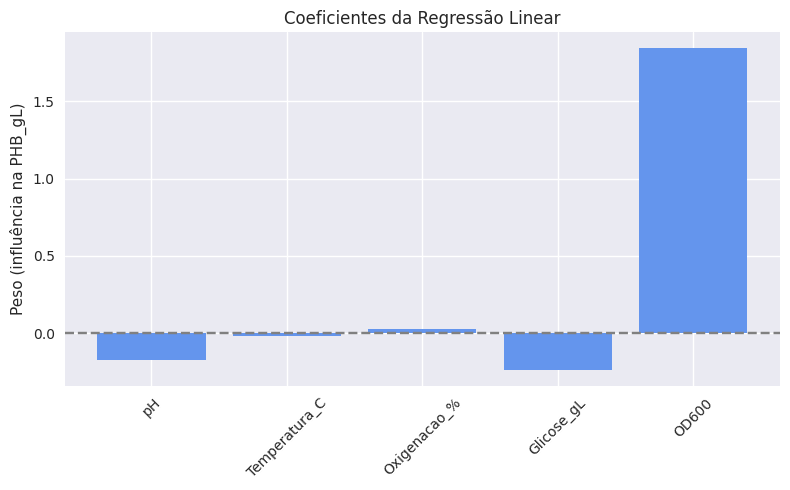

In [108]:
# Lista dos nomes das variáveis e seus coeficientes (theta)
variaveis = ["Intercepto", "pH", "Temperatura_C", "Oxigenacao_%", "Glicose_gL", "OD600"]

# Plotar os coeficientes (exceto o intercepto)
plt.figure(figsize=(8,5))
plt.bar(variaveis[1:], theta[1:], color='cornflowerblue')  # pula o intercepto

plt.title('Coeficientes da Regressão Linear')
plt.ylabel('Peso (influência na PHB_gL)')
plt.xticks(rotation=45)
plt.axhline(0, color='gray', linestyle='--')  # linha horizontal no zero
plt.tight_layout()
plt.show()

In [110]:
# Lista das variáveis sem intercepto
variaveis = ["pH", "Temperatura_C", "Oxigenacao_%", "Glicose_gL", "OD600"]

# Construir a equação como string
equacao = f"PHB_gL = {theta[0]:.4f}"  # Intercepto
for nome, coef in zip(variaveis, theta[1:]):
    sinal = "+" if coef >= 0 else "-"
    equacao += f" {sinal} {abs(coef):.4f} * {nome}"

# Exibir a equação
print("Equação da regressão linear:\n")
print(equacao)


Equação da regressão linear:

PHB_gL = 12.6166 - 0.1739 * pH - 0.0197 * Temperatura_C + 0.0279 * Oxigenacao_% - 0.2380 * Glicose_gL + 1.8419 * OD600


In [95]:
# Seleciona as 10 melhores combinações com maior produtividade
top10 = df.sort_values(by="Produtividade", ascending=False).head(10).copy()

# Reindexa para facilitar o uso nos gráficos
top10.reset_index(drop=True, inplace=True)


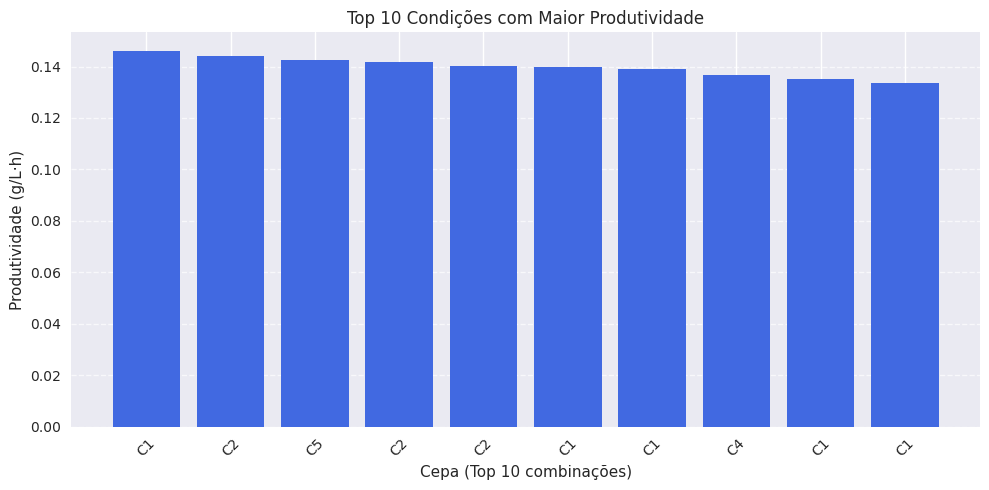

In [96]:
plt.figure(figsize=(10, 5))
plt.bar(range(10), top10["Produtividade"], color="royalblue")
plt.xticks(range(10), top10["Cepa"], rotation=45)
plt.xlabel("Cepa (Top 10 combinações)")
plt.ylabel("Produtividade (g/L·h)")
plt.title("Top 10 Condições com Maior Produtividade")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


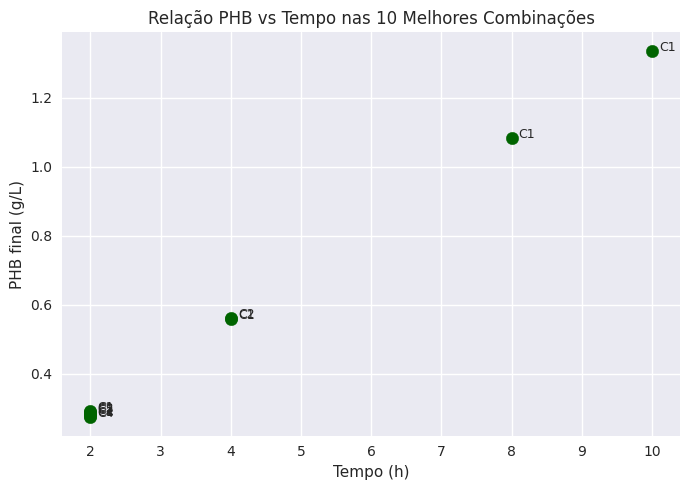

In [101]:
plt.figure(figsize=(7, 5))
plt.scatter(top10["Tempo_h"], top10["PHB_gL"], c="darkgreen", s=80)

for i, cepa in enumerate(top10["Cepa"]):
    plt.text(top10["Tempo_h"][i]+0.1, top10["PHB_gL"][i], str(cepa), fontsize=9)

plt.xlabel("Tempo (h)")
plt.ylabel("PHB final (g/L)")
plt.title("Relação PHB vs Tempo nas 10 Melhores Combinações")
plt.grid(True)
plt.tight_layout()
plt.show()


Existe uma relação direta entre tempo de cultivo e acúmulo de PHB. Reduções drásticas de tempo não compensam.

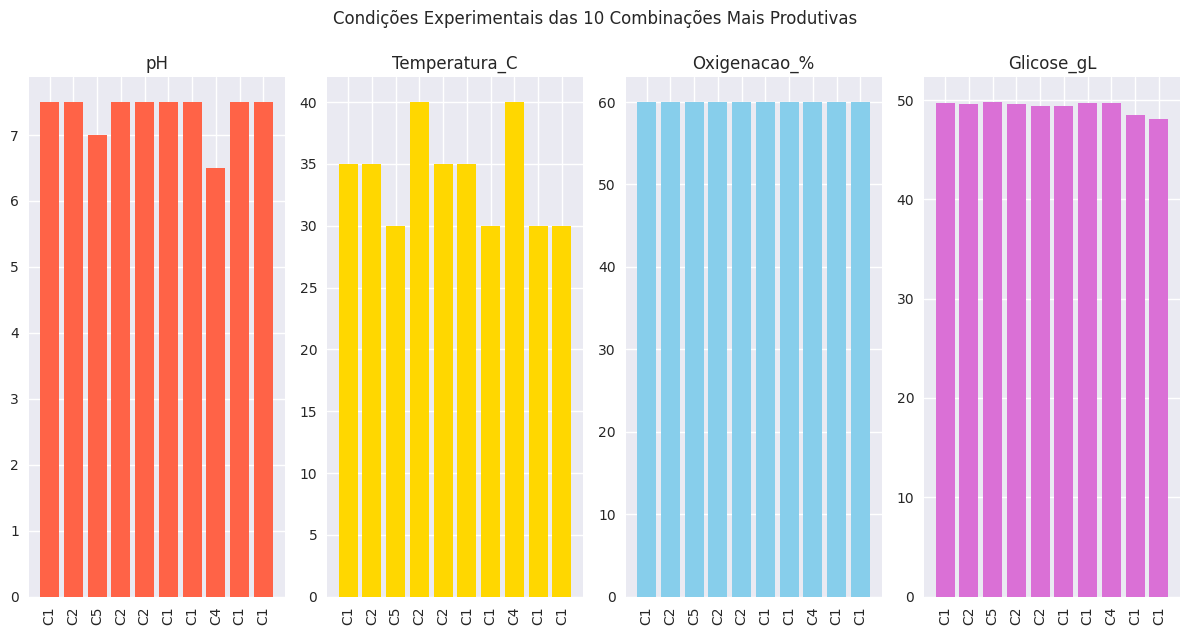

In [102]:
variaveis = ["pH", "Temperatura_C", "Oxigenacao_%", "Glicose_gL"]
cores = ["tomato", "gold", "skyblue", "orchid"]

plt.figure(figsize=(12, 6))
for i, var in enumerate(variaveis):
    plt.subplot(1, 4, i+1)
    plt.bar(range(10), top10[var], color=cores[i])
    plt.xticks(range(10), top10["Cepa"], rotation=90)
    plt.title(var)
    plt.tight_layout()

plt.suptitle("Condições Experimentais das 10 Combinações Mais Produtivas", y=1.05)
plt.show()


pH: As condições mais produtivas tenderam a um pH neutro a levemente alcalino (7.0–7.5), com exceção de uma combinação próxima de 6.5. Isso sugere que ajustes finos no pH impactam fortemente na produtividade do PHB.

Temperatura (°C): Duas faixas se destacam:
Alta produtividade em 30°C e 35°C, comuns na maioria das combinações.
Algumas exceções chegaram a 40°C, o que indica que a cepa utilizada tem tolerância térmica moderada.

Oxigenação (%): 60% de oxigenação foi constante em todas as combinações. Isso indica que alta aeração é fundamental para o metabolismo de produção de PHB — provavelmente influencia positivamente na respiração celular e na conversão da glicose.

Glicose (g/L): Variou entre 48 g/L e 50 g/L, ou seja, concentração elevada de glicose é essencial para alta produção, mas não há ganho adicional claro acima de 50 g/L.

Cepa
C5    0.075910
C1    0.075169
C3    0.075007
WT    0.074893
C2    0.073978
C4    0.073146
Name: eficiencia, dtype: float64


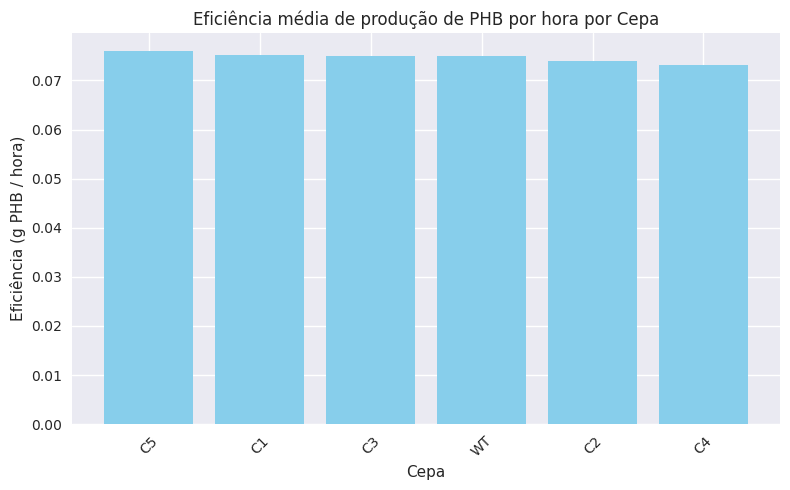

In [107]:
# Criar a métrica eficiência
df['eficiencia'] = df['PHB_gL'] / df['Tempo_h']

# Agrupar e calcular a média da eficiência por cepa
eficiencia_por_cepa = df.groupby('Cepa')['eficiencia'].mean().sort_values(ascending=False)
print(eficiencia_por_cepa)

# Plotar
plt.figure(figsize=(8,5))
plt.bar(eficiencia_por_cepa.index, eficiencia_por_cepa.values, color='skyblue')

plt.title('Eficiência média de produção de PHB por hora por Cepa')
plt.xlabel('Cepa')
plt.ylabel('Eficiência (g PHB / hora)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


pH:
O pH ideal está entre 7.0 e 7.5, favorecendo a melhor produção.
Temperatura:
As faixas mais eficazes são entre 30°C e 35°C, com tolerância até 40°C.
Oxigenação:
Manter uma oxigenação constante em 60% é essencial para alcançar alta produtividade.
Glicose:
A concentração ideal está entre 48 e 50 g/L; quantidades maiores não trazem melhoria na produtividade.
Tempo de cultivo:
Embora alta produtividade exija um tempo maior de cultivo, há possibilidade de otimização para reduzir o tempo sem perda significativa.
Cepa mais produtiva:
C5 com, em média 0.075910 gramas de PHB por hora.
